In [339]:
import cv2
import time
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from enum import Enum

In [340]:
class Actions(Enum):
    UP = 2
    DOWN = 3
    RIGHT = 0
    LEFT = 1

In [341]:
class GridEnvironment(gym.Env):
    def __init__(self, environment_type):
        self.environment_type = environment_type

        self.environment_width = 4
        self.environment_height = 3

        self.observation_space = spaces.Discrete(self.environment_width * self.environment_height)
        self.action_space = spaces.Discrete(4)

        self.agent_pos = np.asarray([0, 0])
        self.positive_pos = np.asarray([[3, 0],[1,1]])
        self.negative_pos = np.asarray([[0,1],[2,2]])
        self.finish=np.asarray([[3,2]])
        
        self.max_timesteps= 11
        self.timestep=0
        self.state=np.zeros((self.environment_width, self.environment_height))
        self.cumulative_reward = 0

    def reset(self, **kwargs):
        self.timestep = 0
        self.cumulative_reward = 0
        self.agent_pos = np.asarray([0, 0])
        self.finish=np.asarray([[3,2]])
        currentState=0
        info={}
        return currentState,info
    

    def step(self, action):
        
        if action == Actions.RIGHT:
            self.agent_pos[0] += 1  # This action causes the agent to go right.
        if action == Actions.LEFT:
            self.agent_pos[0] -= 1  # This action causes the agent to go left.
        if action == Actions.UP:
            self.agent_pos[1] += 1  # This action causes the agent to go up.
        if action == Actions.DOWN:
            self.agent_pos[1] -= 1  # This action causes the agent to go down.
            
        truncated = True if np.all((self.agent_pos >=0 ) & (self.agent_pos <= 3)) else False
        self.agent_pos[0]=np.clip(self.agent_pos[0], 0, 3)
        self.agent_pos[1]=np.clip(self.agent_pos[1], 0, 2)
        
        self.state=np.zeros((self.environment_width, self.environment_height))
        
        self.state[self.agent_pos[0], self.agent_pos[1]] = 1

        currentState = self.agent_pos[1] * self.environment_width + self.agent_pos[0]
        
        reward=0
        
        if any(np.array_equal(self.agent_pos, pos) for pos in self.positive_pos):
            reward += 5
        if any(np.array_equal(self.agent_pos, pos) for pos in self.finish):
            reward += 7
        if any(np.array_equal(self.agent_pos, pos) for pos in self.negative_pos):
            reward -= 5
            
        self.cumulative_reward += reward
        self.timestep += 1

        # Condition to check for termination (episode is over)
        terminated = True if self.timestep >= self.max_timesteps or np.array_equal(self.finish[0], self.agent_pos) else False

        return currentState, self.cumulative_reward, terminated, truncated

    def render(self, mode='human', plot=False):
        
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.set_xlim(0, 4)
        ax.set_ylim(0, 3)

        def plot_image(plot_pos):
            

            # Initially setting every object to not be plotted.
            plot_agent, plot_positive_reward, plot_negative_reward, plot_goal = \
                False, False, False, False

            # Checking which objects need to be plotted by comparing their positions.
            if np.array_equal(self.agent_pos, plot_pos):
                plot_agent = True
                
            if any(np.array_equal(self.positive_pos[i], plot_pos) for i in range(len(self.positive_pos))):
                plot_positive_reward = True
                
            if any(np.array_equal(self.negative_pos[i], plot_pos) for i in range(len(self.negative_pos))):
                plot_negative_reward = True
                
            if any(np.array_equal(self.finish[i], plot_pos) for i in range(len(self.finish))):
                
                plot_goal = True
                
            
            
            # Plot for Agent.
            if plot_agent and \
                    all(not item for item in
                        [plot_positive_reward, plot_negative_reward, plot_goal]):
                agent = AnnotationBbox(OffsetImage(plt.imread('New folder/agent.png'), zoom=0.60),
                                       np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent)

            # Plot for positive_reward.
            elif plot_positive_reward and \
                    all(not item for item in
                        [plot_agent, plot_negative_reward, plot_goal]):
                positive = AnnotationBbox(OffsetImage(plt.imread('New folder/positive.png'), zoom=0.60),
                                        np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(positive)

            # Plot for negative_reward.
            elif  plot_negative_reward and \
                    all(not item for item in
                        [plot_agent, plot_positive_reward, plot_goal]):
                negative = AnnotationBbox(OffsetImage(plt.imread('New folder/negative.png'), zoom=0.60),
                                      np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(negative)

            # Plot for goal.
            elif plot_goal and \
                    all(not item for item in
                        [plot_agent, plot_positive_reward, plot_negative_reward]):
                goal = AnnotationBbox(OffsetImage(plt.imread('New folder/images.jpg'), zoom=0.50),
                                     np.add(plot_pos, [0.5, 0.5]), frameon=False)
        
                ax.add_artist(goal)
                
            # plot for both agent and postive reward
            elif all(item for item in [plot_agent, plot_positive_reward]) and \
                    all(not item for item in
                        [plot_negative_reward, plot_goal]):
                agent_positive = AnnotationBbox(OffsetImage(plt.imread('New folder/agent_positive.png'), zoom=0.55),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_positive)
                
            
            # plot for both agent and negative reward
            elif all(item for item in [plot_agent, plot_negative_reward]) and \
                    all(not item for item in
                        [plot_positive_reward, plot_goal]):
                agent_negative = AnnotationBbox(OffsetImage(plt.imread('New folder/agent_negative.png'), zoom=0.55),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_negative)
            
            # plot for both agent and goal
            elif all(item for item in [plot_agent, plot_goal]) and \
                    all(not item for item in
                        [plot_negative_reward, plot_positive_reward]):
                agent_goal = AnnotationBbox(OffsetImage(plt.imread('New folder/agent_goal.png'), zoom=0.45),
                                              np.add(plot_pos, [0.5, 0.5]), frameon=False)
                ax.add_artist(agent_goal)
                

            

        coordinates_state_mapping_2 = {}
        for j in range(self.environment_height * self.environment_width):
            coordinates_state_mapping_2[j] = np.asarray(
                [j % self.environment_width, int(np.floor(j / self.environment_width))])

        # Rendering the images for all states.
        for position in coordinates_state_mapping_2:
            plot_image(coordinates_state_mapping_2[position])
            

        plt.xticks([0, 1,2,3,4 ])
        plt.yticks([0, 1,2,3])
        plt.grid()

        if plot:  # Displaying the plot.
            plt.show()
        else:  # Returning the preprocessed image representation of the environment.
            fig.canvas.draw()
            img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            width = 84
            height = 84
            dim = (width, height)
            # noinspection PyUnresolvedReferences
            preprocessed_image = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            plt.show()
            return preprocessed_image

the returned state is 11 is terminated True


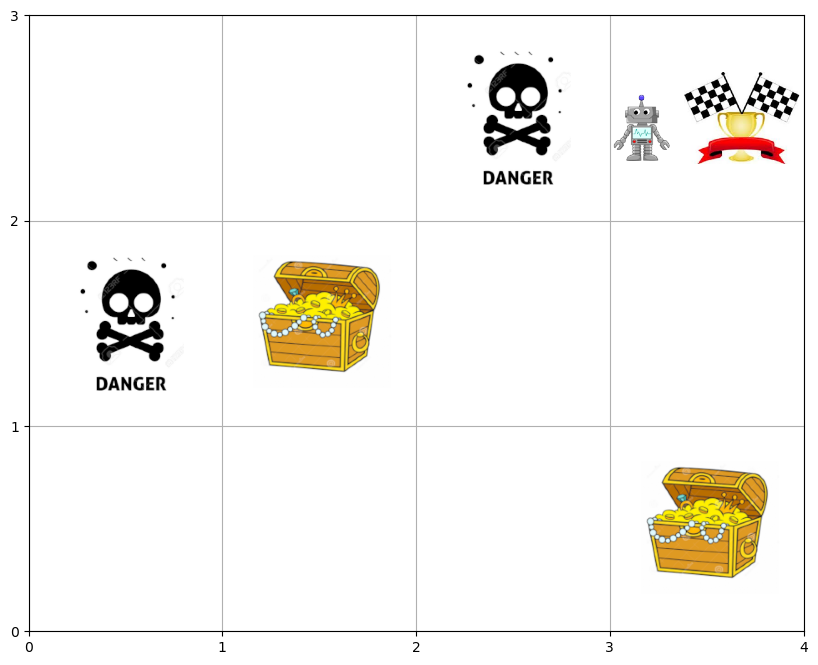

In [38]:
grid_RL = GridEnvironment(environment_type='deterministic')
grid_RL.reset()
obs, reward, terminated, truncated = grid_RL.step(Actions.UP)
obs, reward, terminated, truncated = grid_RL.step(Actions.UP)
obs, reward, terminated, truncated = grid_RL.step(Actions.UP)
obs, reward, terminated, truncated = grid_RL.step(Actions.RIGHT)
obs, reward, terminated, truncated = grid_RL.step(Actions.RIGHT)
obs, reward, terminated, truncated = grid_RL.step(Actions.RIGHT)
# obs, reward, terminated, truncated = grid_RL.step(Actions.RIGHT)
print(f"the returned state is {obs} is terminated {terminated}")
grid_RL.render(plot=True)

In [39]:
class RandomAgent:

  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs):
    return np.random.choice(self.action_space.n)

Current state: 4  Action: Actions.UP , Reward: -5 , Done: False


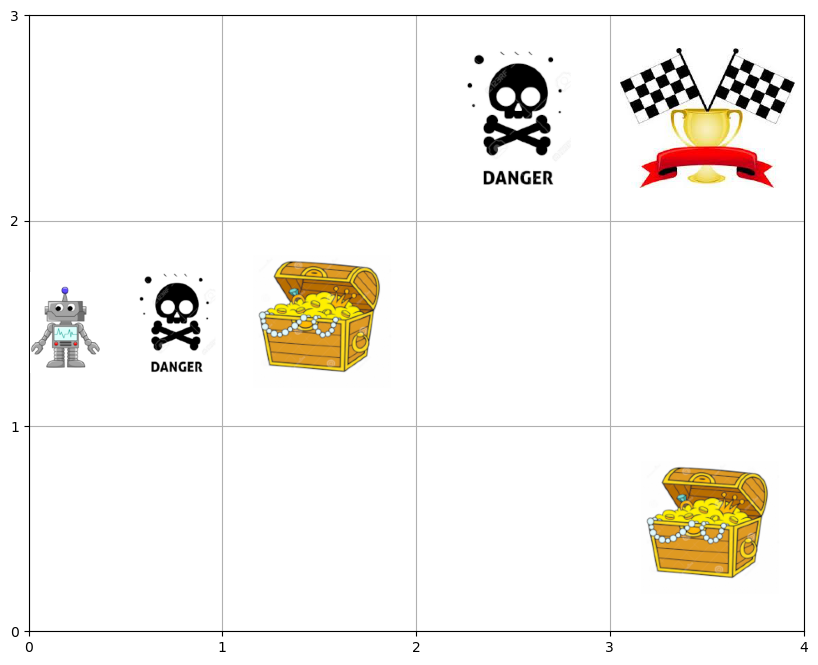

Current state: 4  Action: Actions.LEFT , Reward: -10 , Done: False


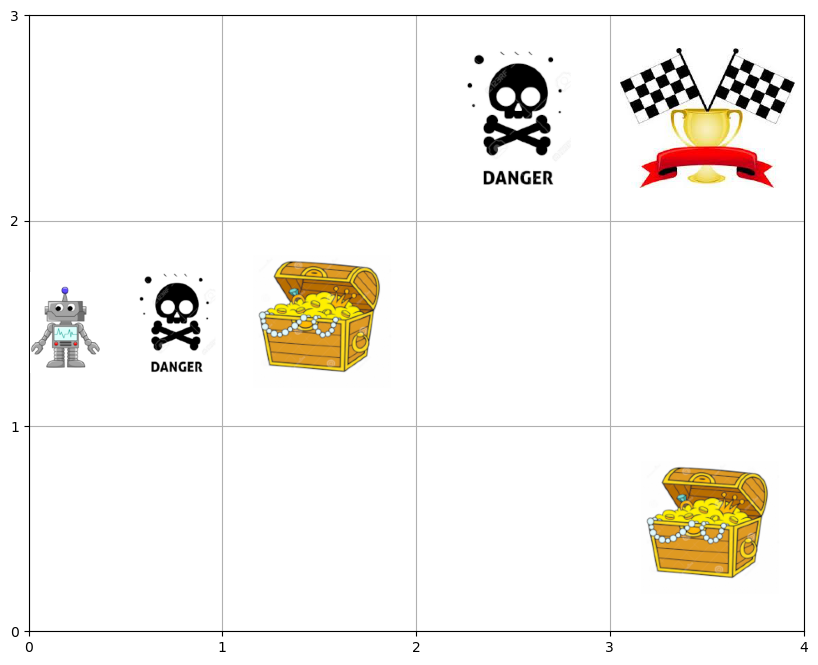

Current state: 4  Action: Actions.LEFT , Reward: -15 , Done: False


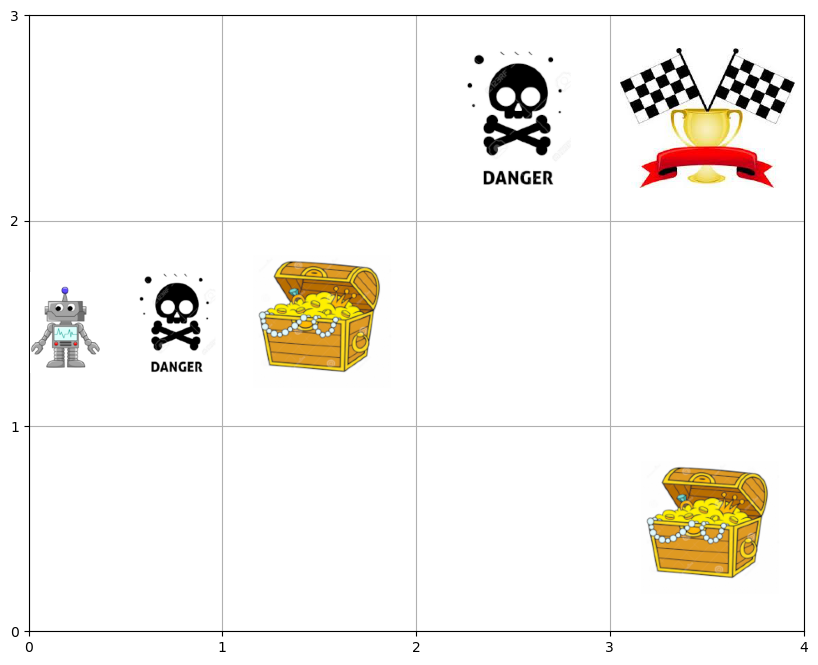

Current state: 5  Action: Actions.RIGHT , Reward: -10 , Done: False


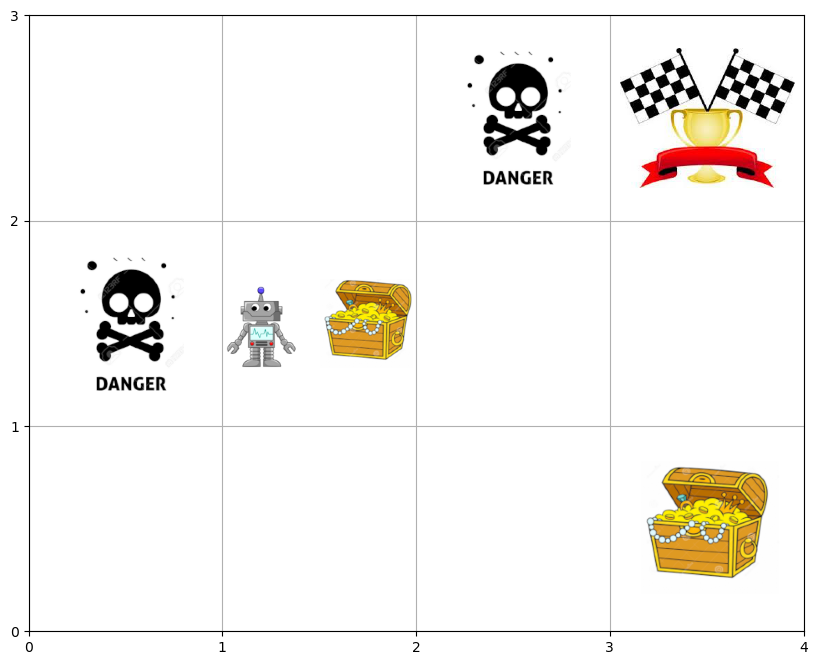

Current state: 9  Action: Actions.UP , Reward: -10 , Done: False


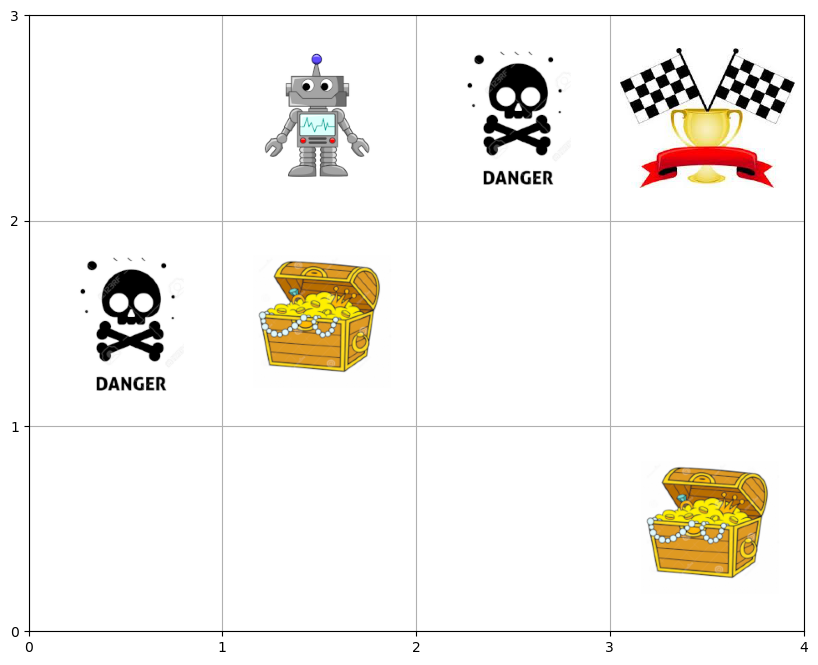

Current state: 5  Action: Actions.DOWN , Reward: -5 , Done: False


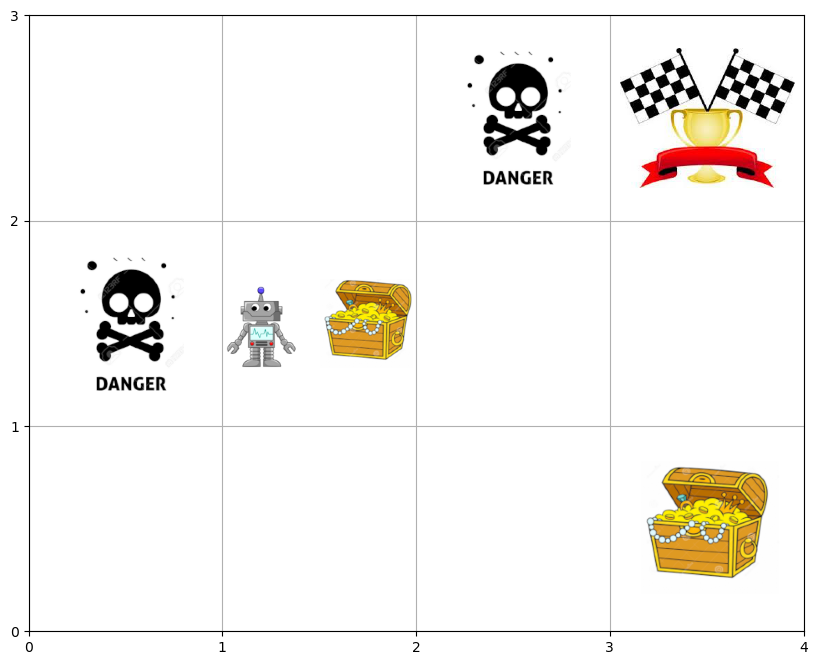

Current state: 1  Action: Actions.DOWN , Reward: -5 , Done: False


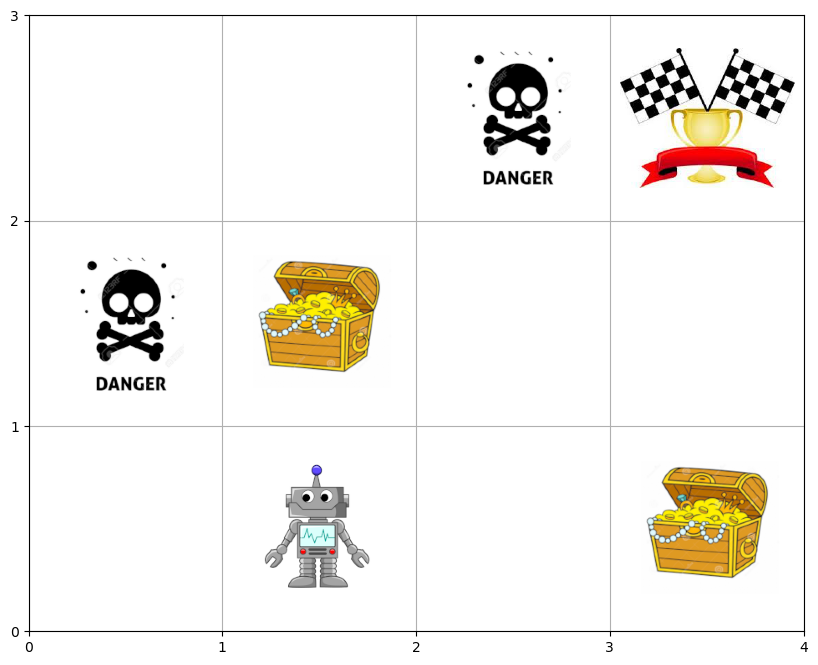

Current state: 0  Action: Actions.LEFT , Reward: -5 , Done: False


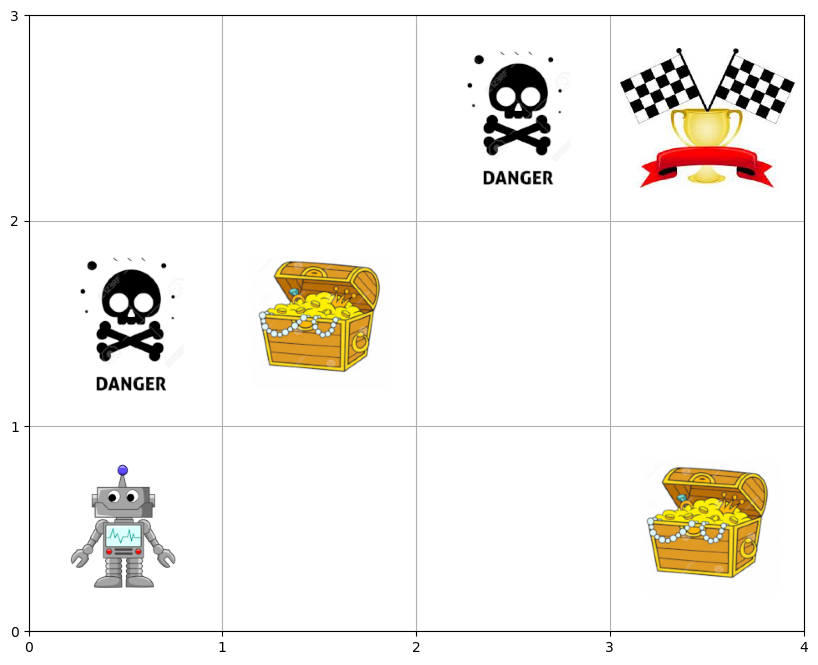

Current state: 0  Action: Actions.LEFT , Reward: -5 , Done: False


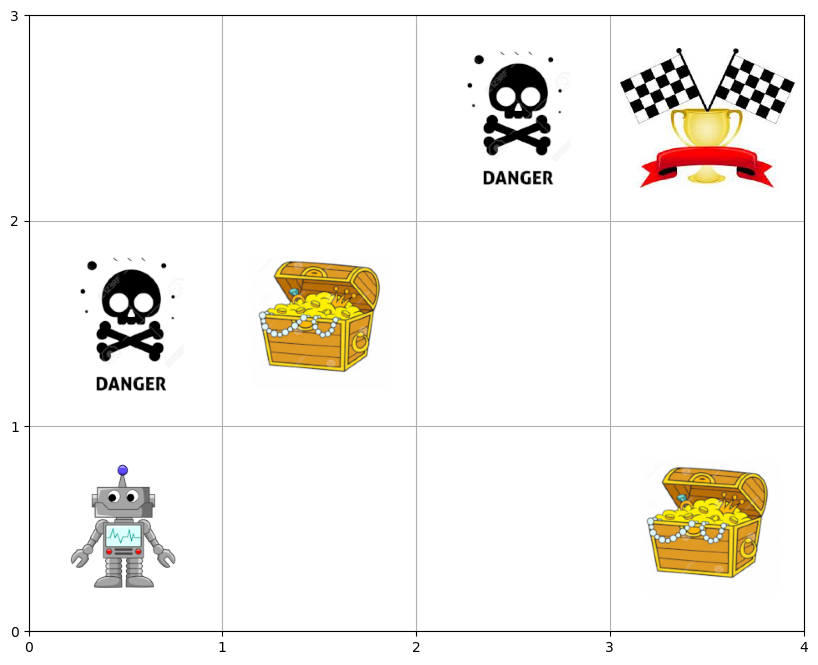

Current state: 0  Action: Actions.LEFT , Reward: -5 , Done: False


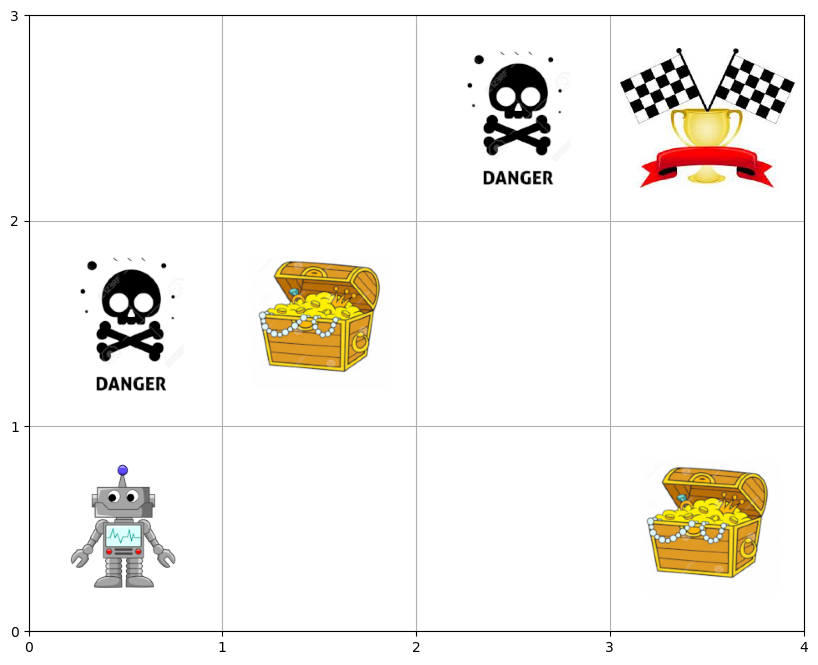

Current state: 1  Action: Actions.RIGHT , Reward: -5 , Done: True


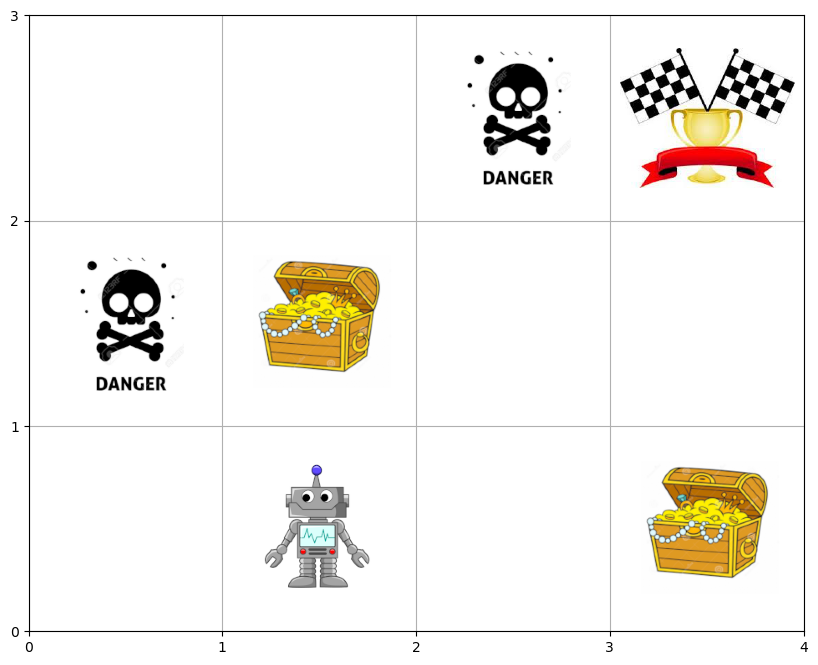

In [40]:
if __name__ == '__main__':
  env = GridEnvironment(environment_type='deterministic')
  agent = RandomAgent(env)

  obs, info = env.reset()
  terminated, truncated = False, False

  while not terminated:
    action = agent.step(obs)
    obs, reward, terminated, truncated = env.step(Actions(action))
    print('Current state:', obs, ' Action:', Actions(action), ', Reward:', reward, ', Done:', terminated)
    env.render()
    time.sleep(1)

### Part 2

In [342]:
def choose_action(state, epsilon, Q):
    action = 0
    if np.random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state])
    return action

def update(state, state2, reward, action, action2, alpha, gamma, Q):
    predict = Q[state, action]
    target = reward + gamma * Q[state2, action2]
    Q[state, action] = Q[state, action] + alpha * (target - predict)

In [261]:
def doSARSALearn(epsilon, total_episodes, alpha, gamma, epsilonDecay):
    env = GridEnvironment(environment_type='deterministic')
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    totalEpisodesRewards = []
    epsilonPerEpisode = []
    print("Initial Q table")
    print(Q)
    for episode in range(total_episodes):
        epsilonPerEpisode.append(epsilon)
        state1, info = env.reset()
        action1 = choose_action(state1, epsilon, Q)
        terminated, truncated = False, False
        total_reward = 0

        while not terminated:
            state2, reward, terminated, info = env.step(Actions(action1))
            action2 = choose_action(state2, epsilon, Q)
            update(state1, state2, reward, action1, action2, alpha, gamma, Q)

            state1 = state2
            action1 = action2

            total_reward += reward
        
        if epsilon > 0.01:
            epsilon -= epsilonDecay
        totalEpisodesRewards.append(total_reward)
        
    print("\nTrained Q table")
    print(Q)
    return Q, totalEpisodesRewards, epsilonPerEpisode

In [266]:
Q, totalEpisodesRewards, epsilonPerEpisode = doSARSALearn(epsilon = 1, total_episodes=500, alpha=0.1, gamma=0.95, epsilonDecay=0.009)

Initial Q table
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q table
[[240.99217364  33.23588432  24.33943653  17.57555306]
 [ 17.4652885   79.44053518 260.40482485 103.75886827]
 [ 40.67071743   7.25919246   2.75155544   3.34418304]
 [ 10.2646215   36.75979189   3.59011948  16.80421736]
 [157.17839503  -9.40343752  -5.97172762   0.28532577]
 [ 60.19122375  59.35942776  46.60387299 260.61494611]
 [  1.67442175 129.40870982  -1.08620998   7.23410101]
 [  1.32920373   1.83365207   5.052513     0.        ]
 [ -3.49304973  -3.77237023  -5.8807217   -7.36115312]
 [ -5.93697874  -0.88541132   0.65859143 124.85018561]
 [ -1.523       -2.56954738  -3.00587271  -2.9657831 ]
 [  0.           0.           0.           0.        ]]


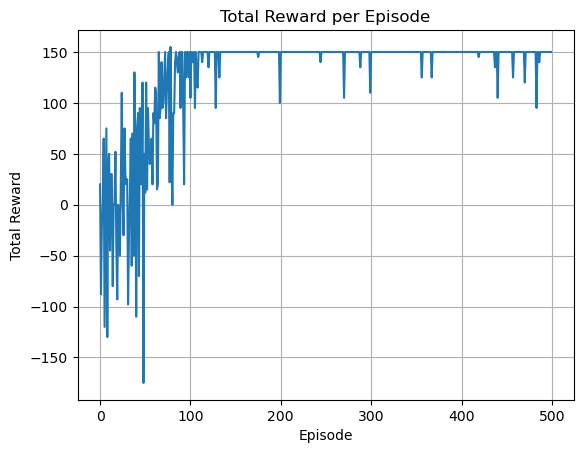

In [267]:
plt.plot(totalEpisodesRewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

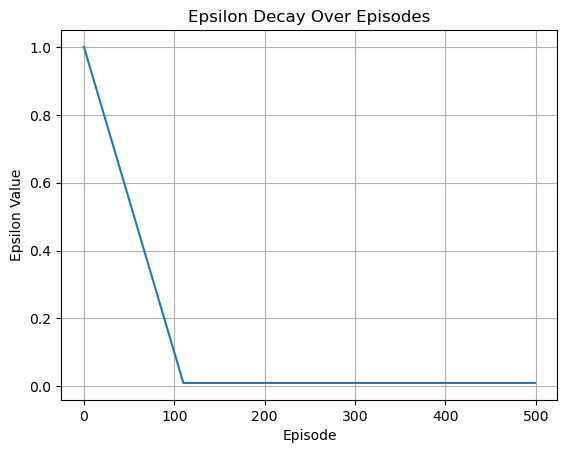

In [268]:
plt.plot(epsilonPerEpisode)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

## Step 2.d
### Only Greedy action taken 

In [269]:
print(Q)

[[240.99217364  33.23588432  24.33943653  17.57555306]
 [ 17.4652885   79.44053518 260.40482485 103.75886827]
 [ 40.67071743   7.25919246   2.75155544   3.34418304]
 [ 10.2646215   36.75979189   3.59011948  16.80421736]
 [157.17839503  -9.40343752  -5.97172762   0.28532577]
 [ 60.19122375  59.35942776  46.60387299 260.61494611]
 [  1.67442175 129.40870982  -1.08620998   7.23410101]
 [  1.32920373   1.83365207   5.052513     0.        ]
 [ -3.49304973  -3.77237023  -5.8807217   -7.36115312]
 [ -5.93697874  -0.88541132   0.65859143 124.85018561]
 [ -1.523       -2.56954738  -3.00587271  -2.9657831 ]
 [  0.           0.           0.           0.        ]]


In [270]:
def doGreedyActions(Q):
    total_episodes=10
    env = GridEnvironment(environment_type='deterministic')
    totalEpisodesRewards = []
    for episode in range(total_episodes):
        state1, info = env.reset()
        action1 = np.argmax(Q[state1])
        terminated, truncated = False, False
        total_reward = 0

        while not terminated:
            state2, reward, terminated, info = env.step(Actions(action1))
            action2 = np.argmax(Q[state2])

            state1 = state2
            action1 = action2

            total_reward += reward
        totalEpisodesRewards.append(total_reward)
    return totalEpisodesRewards

In [271]:
totalEpisodesRewards = doGreedyActions(Q=Q)

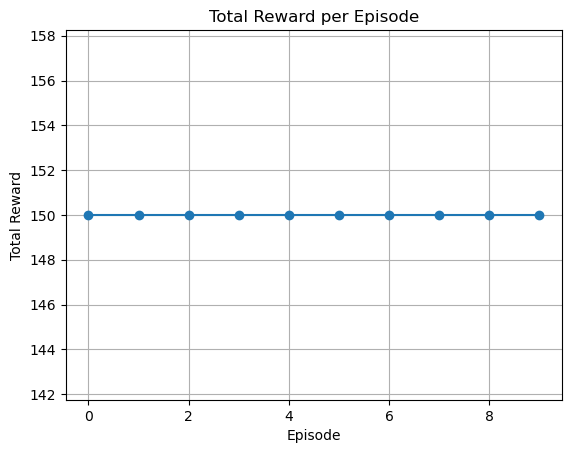

In [272]:
plt.plot(totalEpisodesRewards, marker='o')
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

### 3. Hyper parameter tuning

### First hyper parameter we are choosing is Discount factor (γ) 

#### First try with gamma=0.80

In [254]:
Q, totalEpisodesRewards, epsilonPerEpisode = doSARSALearn(epsilon = 1, total_episodes=500, alpha=0.1, gamma=0.80, epsilonDecay=0.009)

Initial Q table
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q table
[[59.28168461 15.38010784 -1.4260124   7.92331064]
 [21.49702695 31.75136769 74.02651149 37.41459106]
 [42.37638624  3.91285511  4.61549754  2.05981381]
 [76.59888635 11.64053926  8.11605741 23.16009954]
 [44.32152925 -4.41660821 -2.07999217 -2.54321097]
 [35.55357216 26.11119303 28.00274984 74.12411576]
 [ 7.13461036 54.37926521  1.04433011  4.5181541 ]
 [ 0.          1.04112115  2.78       15.58577872]
 [-0.88411656  0.92006215 -2.39275542 -4.154     ]
 [-1.33220727 -2.2008936   3.41201279 40.58349266]
 [ 0.         -0.49697415 -0.81402211  6.61382405]
 [ 0.          0.          0.          0.        ]]


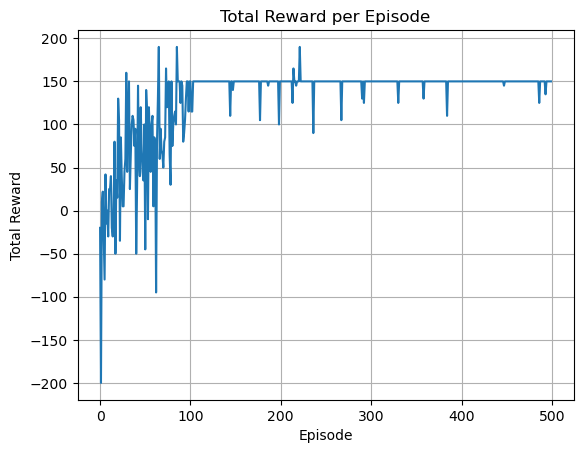

In [255]:
plt.plot(totalEpisodesRewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

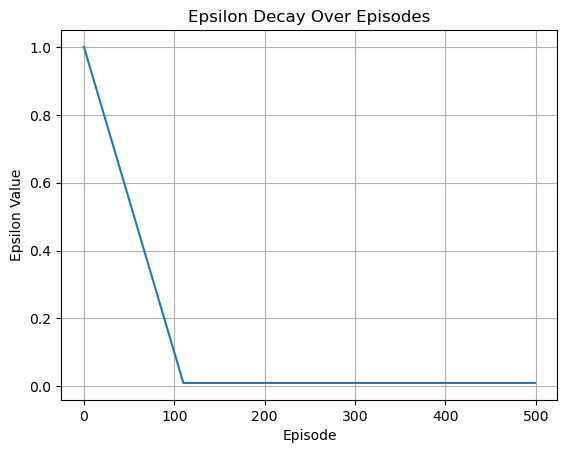

In [256]:
plt.plot(epsilonPerEpisode)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

#### Greedy policy

In [ ]:
totalEpisodesRewards = doGreedyActions(Q=Q)

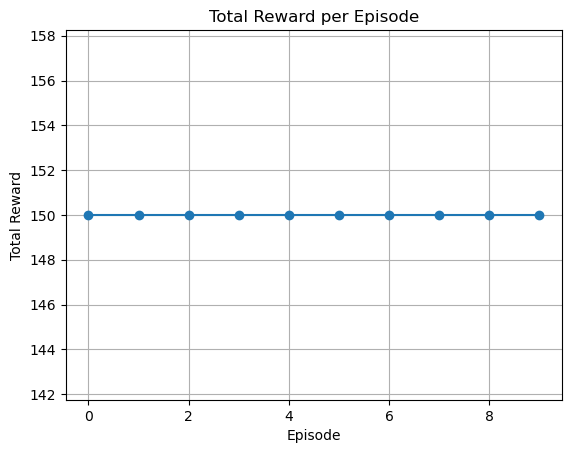

In [259]:
plt.plot(totalEpisodesRewards, marker='o')
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

#### Second try with gamma=0.4

In [275]:
Q, totalEpisodesRewards, epsilonPerEpisode = doSARSALearn(epsilon = 1, total_episodes=500, alpha=0.1, gamma=0.4, epsilonDecay=0.009)

Initial Q table
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q table
[[10.31632761 -1.11528645 -4.86791224  1.31030677]
 [11.19684372  7.84650356 24.16045763 11.90337938]
 [21.53796993  3.84216635 -0.06664616  6.50953002]
 [40.97499066 13.94215113 17.66118377 19.36057039]
 [13.7063168  -8.33715224 -4.65681705 -6.14097977]
 [16.1527963   9.53682294 17.06220463 24.41197315]
 [ 2.21919081 17.36174628 -0.97193076  3.30385499]
 [ 5.47680742  0.28878066 13.62294943  8.15348796]
 [-3.37103721 15.40138304 -3.70824673 -4.986295  ]
 [-2.0518689  13.64715664 -0.08840459  0.94563105]
 [-0.0817      0.36296331  0.         -1.06209488]
 [ 0.          0.          0.          0.        ]]


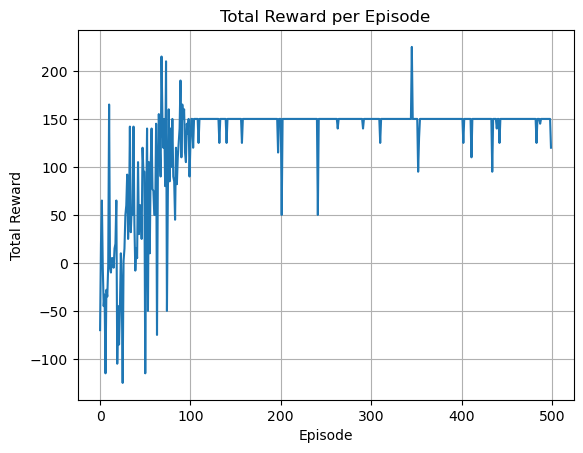

In [276]:
plt.plot(totalEpisodesRewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

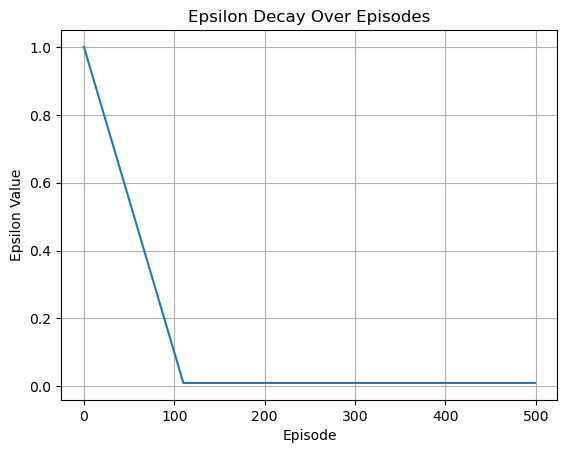

In [277]:
plt.plot(epsilonPerEpisode)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

#### Greedy policy

In [278]:
totalEpisodesRewards = doGreedyActions(Q=Q)

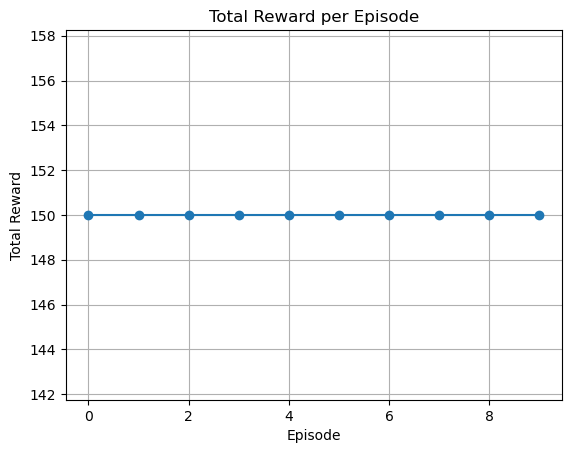

In [279]:
plt.plot(totalEpisodesRewards, marker='o')
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

#### Third try with gamma=2

In [297]:
Q, totalEpisodesRewards, epsilonPerEpisode = doSARSALearn(epsilon = 1, total_episodes=500, alpha=0.1, gamma=2, epsilonDecay=0.009)

Initial Q table
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q table
[[ 9.01810976e+132  3.85827021e+101  7.39940520e+000  7.29398996e+002]
 [ 4.64032146e+133  2.85699796e+004  1.39790827e+001  4.65034336e+131]
 [ 2.64054502e+134  6.81867708e+108  5.52077372e+064  2.50969946e+003]
 [ 1.62083912e+135  1.22382103e+128  1.75692733e+006  2.09534861e+077]
 [ 3.48689369e+000 -5.66971874e+000 -6.23904875e+000  6.54668824e+004]
 [ 1.28232718e+001 -6.00935481e+000  2.80752121e+001  1.28065454e+001]
 [ 1.50771770e+002  9.35565975e+000 -1.92377373e+000  1.05777366e+132]
 [ 6.30115320e+000  1.19093278e+106  1.23903710e+001  4.39564675e+000]
 [ 1.89921395e+000 -5.45348718e-001 -2.01823282e+000 -7.17995358e+000]
 [ 6.78338471e-001  5.60672672e-001  2.17575584e+000  2.29452388e+001]
 [ 1.73280000e+000 -3.62397120e-001 -9.60000000e-001 -5.04366267e-002]
 [ 0.

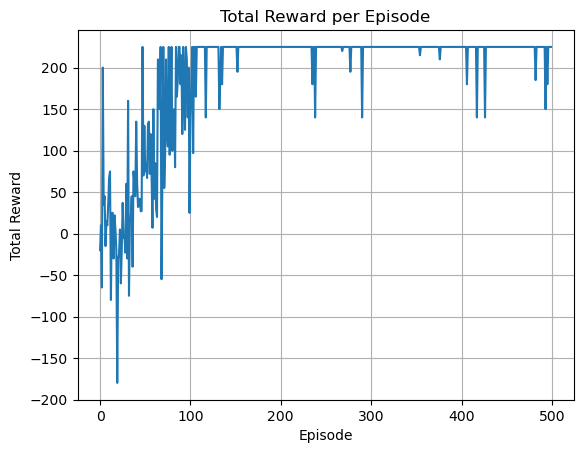

In [298]:
plt.plot(totalEpisodesRewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

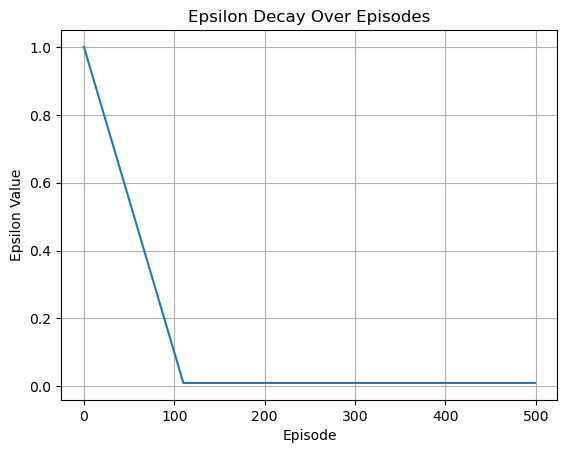

In [299]:
plt.plot(epsilonPerEpisode)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

#### Greedy policy

In [300]:
totalEpisodesRewards = doGreedyActions(Q=Q)

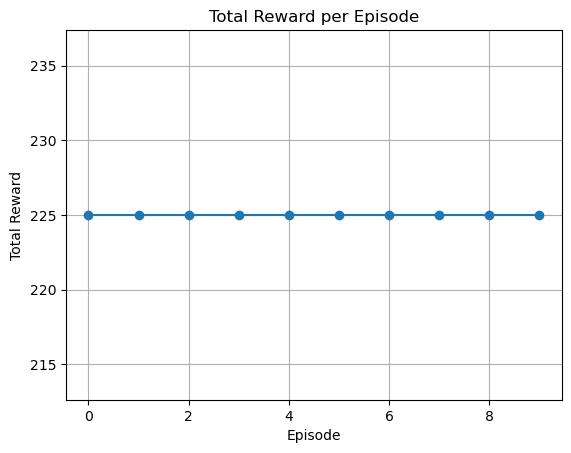

In [301]:
plt.plot(totalEpisodesRewards, marker='o')
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

### Second hyper parameter we are choosing is epsilonDecay

#### First try with epsilonDecay=0.001

In [302]:
Q, totalEpisodesRewards, epsilonPerEpisode = doSARSALearn(epsilon = 1, total_episodes=500, alpha=0.1, gamma=0.80, epsilonDecay=0.001)

Initial Q table
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q table
[[ 22.65123256  14.70215213  -3.31288237  12.08288324]
 [ 45.37062337  12.61835127  21.08864659  24.96612049]
 [ 62.80653649  28.36584257  24.24320803  33.76384402]
 [ 78.27187646  59.07209623  59.5691274   71.94455003]
 [ 16.21609239 -13.90191547 -11.25094379   1.49178837]
 [ 17.31111114  -0.24408601   2.02333318  31.10532753]
 [ 36.10552131  16.95602841  -3.87440381  27.28475541]
 [ 31.30187517  27.49605915  16.00938703  69.26006966]
 [ -0.8835098   -8.95331214  -7.81907941  -8.58920942]
 [ -7.24821177  -5.95947017   2.16631433  12.39420296]
 [  1.20323948  -4.45817059 -10.13228469   5.30043042]
 [  0.           0.           0.           0.        ]]


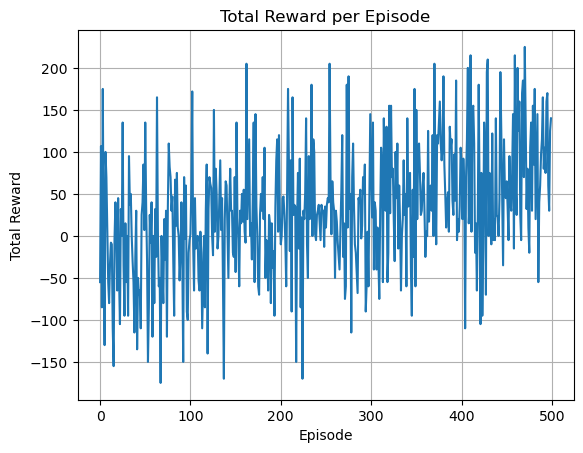

In [303]:
plt.plot(totalEpisodesRewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

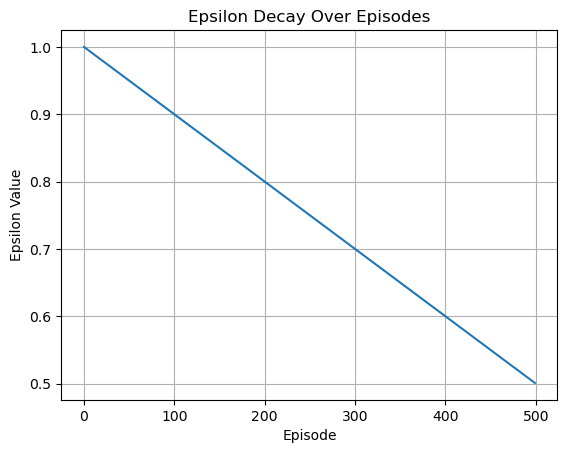

In [304]:
plt.plot(epsilonPerEpisode)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

#### Greedy policy

In [305]:
totalEpisodesRewards = doGreedyActions(Q=Q)

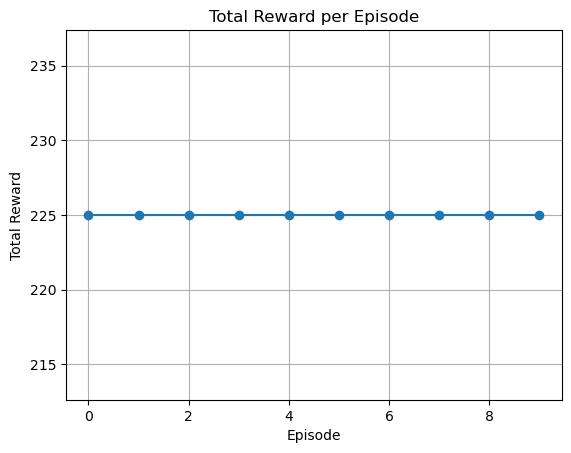

In [306]:
plt.plot(totalEpisodesRewards, marker='o')
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

#### Second try with epsilonDecay=0.05

In [328]:
Q, totalEpisodesRewards, epsilonPerEpisode = doSARSALearn(epsilon = 1, total_episodes=500, alpha=0.1, gamma=0.80, epsilonDecay=0.05)

Initial Q table
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q table
[[ 4.50057736e+01 -7.82665605e-01 -3.98229135e+00 -7.47394485e-01]
 [ 5.62572170e+01  5.78084736e-01 -6.85512549e-02  0.00000000e+00]
 [ 7.03215212e+01  3.84916476e-01  8.78000000e-01  4.70680323e+00]
 [ 0.00000000e+00  6.83636212e+01  1.00000000e+00  2.32346477e+00]
 [-1.73956134e+00 -3.37829331e+00 -2.69794040e+00 -1.86891526e+00]
 [-7.06783584e-01 -1.09760000e+00 -1.12000000e+00 -5.23012394e-01]
 [ 1.13680288e+00 -4.86000000e-01 -9.54000000e-01 -5.00000000e-01]
 [ 1.00000000e+00  1.71688023e+00  0.00000000e+00  6.46992000e-01]
 [-1.85500000e+00 -9.50000000e-01 -1.54038240e+00 -1.93600000e+00]
 [-2.85000000e+00 -5.40000000e-01 -2.85345600e+00 -1.03888000e+00]
 [ 0.00000000e+00 -1.50000000e+00  0.00000000e+00 -7.64101760e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00

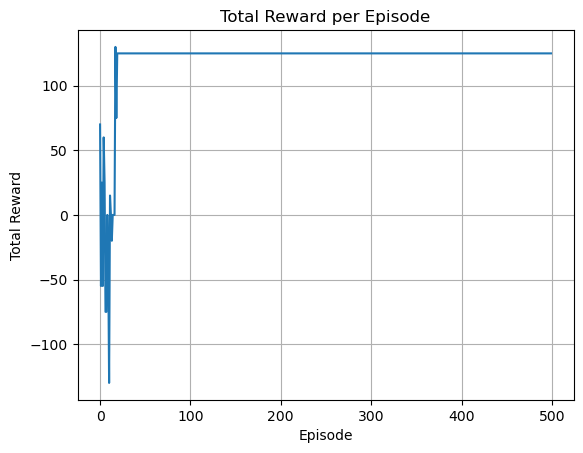

In [329]:
plt.plot(totalEpisodesRewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

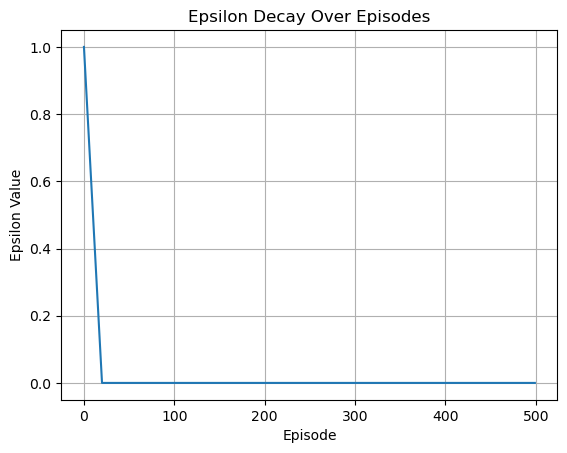

In [330]:
plt.plot(epsilonPerEpisode)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

#### Greedy policy

In [331]:
totalEpisodesRewards = doGreedyActions(Q=Q)

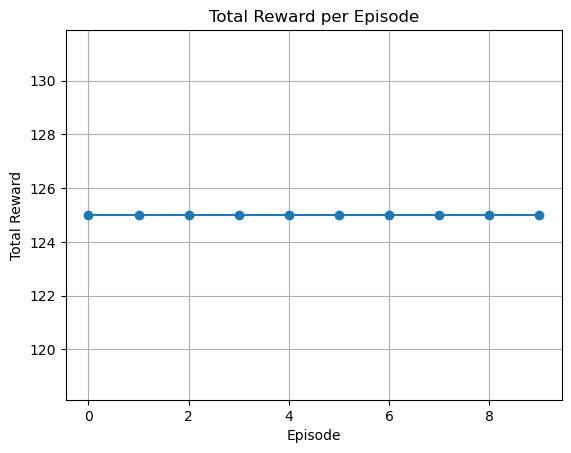

In [332]:
plt.plot(totalEpisodesRewards, marker='o')
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

#### Third try with epsilonDecay=0.0007

In [333]:
Q, totalEpisodesRewards, epsilonPerEpisode = doSARSALearn(epsilon = 1, total_episodes=500, alpha=0.1, gamma=0.80, epsilonDecay=0.0007)

Initial Q table
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Trained Q table
[[ 14.58030297   7.15772245  -5.82213209   5.43022036]
 [ 26.71226015   2.95424535  11.72360456  18.25657295]
 [ 50.55102751  16.12107661  23.07643504  30.19154706]
 [ 57.60150509  39.43157811  35.9063137   61.63229274]
 [  7.08091119 -12.49486326 -12.98294785  -1.78796279]
 [ 14.21485041  -8.73516103   5.85258659  19.01921752]
 [ 34.08578813  15.93427283  -3.88092601  27.98640139]
 [ 27.63866045  23.7609845   16.0549099   52.14383951]
 [  2.21578126 -12.61851395  -9.97059924 -16.18219495]
 [ -4.23809246  -3.76571273   3.30571858  14.37592172]
 [  3.01253611  -6.86343996 -11.68102044   1.38938675]
 [  0.           0.           0.           0.        ]]


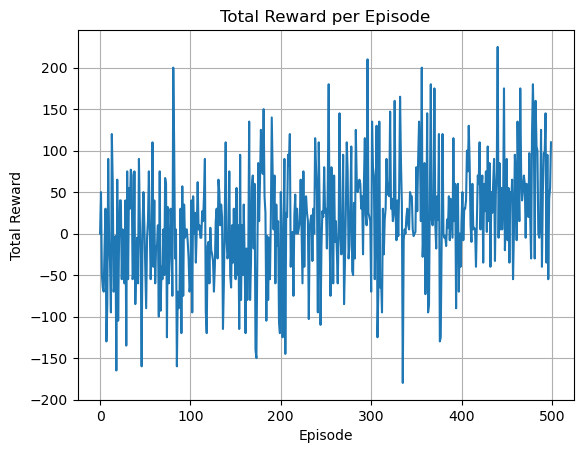

In [334]:
plt.plot(totalEpisodesRewards)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

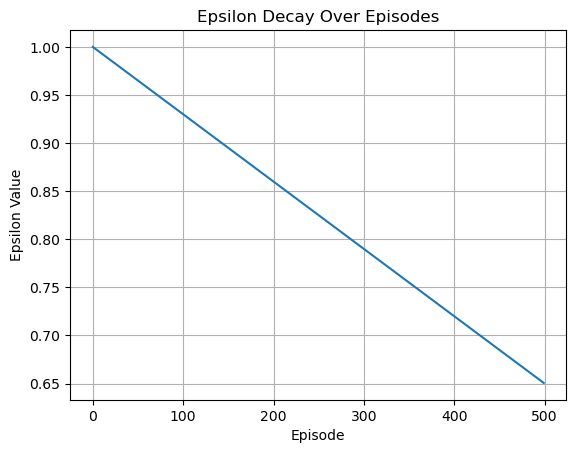

In [335]:
plt.plot(epsilonPerEpisode)
plt.title('Epsilon Decay Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.grid(True)
plt.show()

#### Greedy policy

In [337]:
totalEpisodesRewards = doGreedyActions(Q=Q)

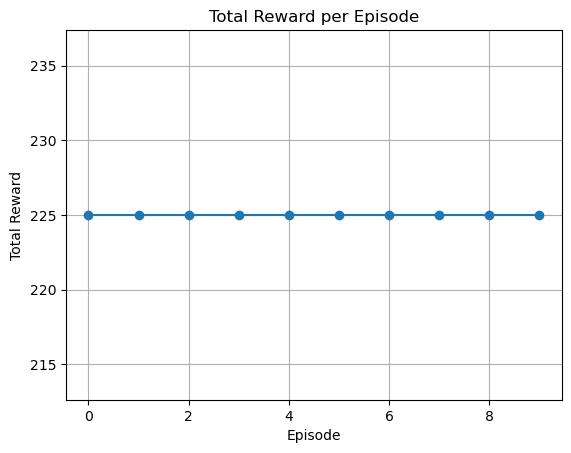

In [338]:
plt.plot(totalEpisodesRewards, marker='o')
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()